# Querying the data lake with Apache Spark on EMR

We see how to query the data lake in-place. 

Some exemplary queries have been given here.

The queries are supposed to be run in an EMR on EC2 instances. The code to run the queries on EMR is in **emr_cluster_submit-Queries.py**, to instantiate the EMR cluster, and in **spark_4_emr_Queries.py**, containing the actual code to be run in the EMR cluster as added EMR step.

The results of the queries are stored in a json file **query_results.json**.

In this notebook the queries are run locally.

## The queries
Imports and visualization configuration:

In [1]:
import re
import os
import time
import json
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, lit, explode, split, regexp_extract, col, isnan, isnull, desc, when, sum, to_date, desc, regexp_replace, count, to_timestamp
from pyspark.sql.types import IntegerType, TimestampType

import boto3
import configparser

#import custom module
from lib import emr_cluster

#setting visualization options
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)  

# modify visualization of the notebook, for easier view
from IPython.core.display import display, HTML
display(HTML("""<style> p { max-width:90% !important; } h1 {font-size:2rem!important } h2 {font-size:1.6rem!important } 
h3 {font-size:1.4rem!important } h4 {font-size:1.3rem!important }h5 {font-size:1.2rem!important }h6 {font-size:1.1rem!important }</style>"""))

Import configuration parameters, to configure Amazon services access, paths, etc.

In [2]:
is_local = True # work with local data or S3 data

# parsing configuration parameters
config = configparser.ConfigParser()

config.read_file(open('config.cfg'))

KEY     = config['AWS']['AWS_ACCESS_KEY_ID']
SECRET  = config['AWS']['AWS_SECRET_ACCESS_KEY']

S3_BUCKET         = config['S3']['S3_bucket']
S3_LAKE_RAWDATA   = config['S3']['RAW_DATA']
S3_PROC_DATA      = config['S3']['PROC_DATA']
S3_PROC_DATA_JSON = config['S3']['PROC_DATA_JSON']
S3_I94_DATA       = config['S3']['I94_DATA']

if is_local:
    S3_bucket_I94 = 'data/S3bucket_temp/I94_data' #for local testing
else:
    S3_bucket_I94 = os.path.join('s3a://',S3_BUCKET, S3_PROC_DATA, S3_I94_DATA)

AWS_ACCESS_KEY_ID     = config['AWS']['AWS_ACCESS_KEY_ID']
AWS_SECRET_ACCESS_KEY = config['AWS']['AWS_SECRET_ACCESS_KEY']

Instantiating a new SparkSession with AWS support

In [3]:
spark = SparkSession.builder\
                    .config("spark.jars.packages","org.apache.hadoop:hadoop-aws:2.7.0")\
                    .enableHiveSupport()\
                    .getOrCreate()

Setting access and secret key to allow EMR access to S3

In [4]:
hadoopConf = spark.sparkContext._jsc.hadoopConfiguration()
hadoopConf.set("fs.s3a.access.key", AWS_ACCESS_KEY_ID)
hadoopConf.set("fs.s3a.secret.key", AWS_SECRET_ACCESS_KEY)

##### Query 0. How are distribuited the arrivals in USA, in a given period?

In [5]:
first_day = '2016-04-25'
last_day  = '2016-04-30'

df_I94 = spark.read.format("parquet").load(S3_bucket_I94).where((col('arrdate')>=first_day) & (col('arrdate')<=last_day))

df_query_0 = df_I94.groupBy('arrdate').sum('count').orderBy('arrdate').toPandas()

df_query_0.head(30)


,arrdate,sum(count)
0,2016-04-25,99652
1,2016-04-26,88100
2,2016-04-27,99259
3,2016-04-28,120971
4,2016-04-29,128267
5,2016-04-30,127155


<font color='red'>Interesting enough, there are apparently no filed I94 records in the days from 2016-04-01 to 2016-04-09. This is something that should be investigated further to understand if there is an error in the data.</font>

##### Query 1. For each port, in a given period, how many arrivals by day there are?

Since the parquet data is partitioned using, in order, year, month, reading the data into a dataframe is very efficient.  

In [6]:
first_day = '2016-04-20'
last_day  = '2016-04-25'

df_I94 = spark.read.format("parquet").load(S3_bucket_I94).where((col('arrdate')>=first_day) & (col('arrdate')<=last_day))

retain_columns = ['i94port', 'arrdate','count']
df_I94_port_vs_date = df_I94.select(retain_columns).groupBy('i94port').pivot('arrdate').sum('count')
df_I94_port_vs_date = df_I94_port_vs_date.na.fill(0)
df_I94_port_vs_date.toPandas().head()

,i94port,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24,2016-04-25
0,BGM,6,2,7,1,7,4
1,FMY,118,293,347,342,123,104
2,DNS,0,0,1,4,1,0
3,MOR,2,0,0,2,0,0
4,HVR,0,2,1,4,2,0


###### Query 1.1. For a list of port, and given period, how many arrivals per day? 

In [7]:
first_day = '2016-04-20'
last_day  = '2016-04-25'

ports_list = ['NYC', 'MIA', 'LOS', 'SFR'] #New York City, Miami, los Angeles, San Francisco

df_I94 = spark.read.format("parquet").load(S3_bucket_I94).where((col('arrdate')>=first_day) & (col('arrdate')<=last_day))
df_I94 = df_I94.where(df_I94.i94port.isin(ports_list))

retain_columns = ['i94port', 'arrdate', 'depdate', 'dtadfile', 'i94bir','count']
df_I94_port_vs_date = df_I94.select(retain_columns).groupBy('i94port').pivot('arrdate').sum('count')
df_I94_port_vs_date = df_I94_port_vs_date.na.fill(0)
df_I94_port_vs_date.toPandas().head()

,i94port,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24,2016-04-25
0,SFR,4594,4798,5749,5578,5517,5641
1,MIA,11972,13490,13964,13983,11315,10350
2,LOS,10347,10615,10240,10532,9596,9932
3,NYC,16694,18836,20634,21083,17516,16424


##### Query 2. Where are the I94 applicants **coming** from, in a given period? 

I want to know the 10 most represented nations

In [8]:
first_day = '2016-04-15'
last_day  = '2016-04-30'

df_I94 = spark.read.format("parquet").load(S3_bucket_I94).where((col('arrdate')>=first_day) & (col('arrdate')<=last_day))

df_I94_count_visitors = df_I94.groupby("i94res").count()\
                                .sort(col("count").desc())
df_I94_count_visitors.show(10)

+------+------+
|i94res| count|
+------+------+
|   135|180136|
|   209|141737|
|   245|110948|
|   582|102104|
|   111| 97253|
|   112| 85412|
|   689| 76083|
|   276| 74436|
|   213| 65906|
|   438| 57686|
+------+------+
only showing top 10 rows



The country codes aren't very informative, therefore I'm going to join with the dataframe **df_I94CIT_RES_multi_rows_filtered** on the field **i94res** to get the country name.

Finally visualize it in a bar plot.

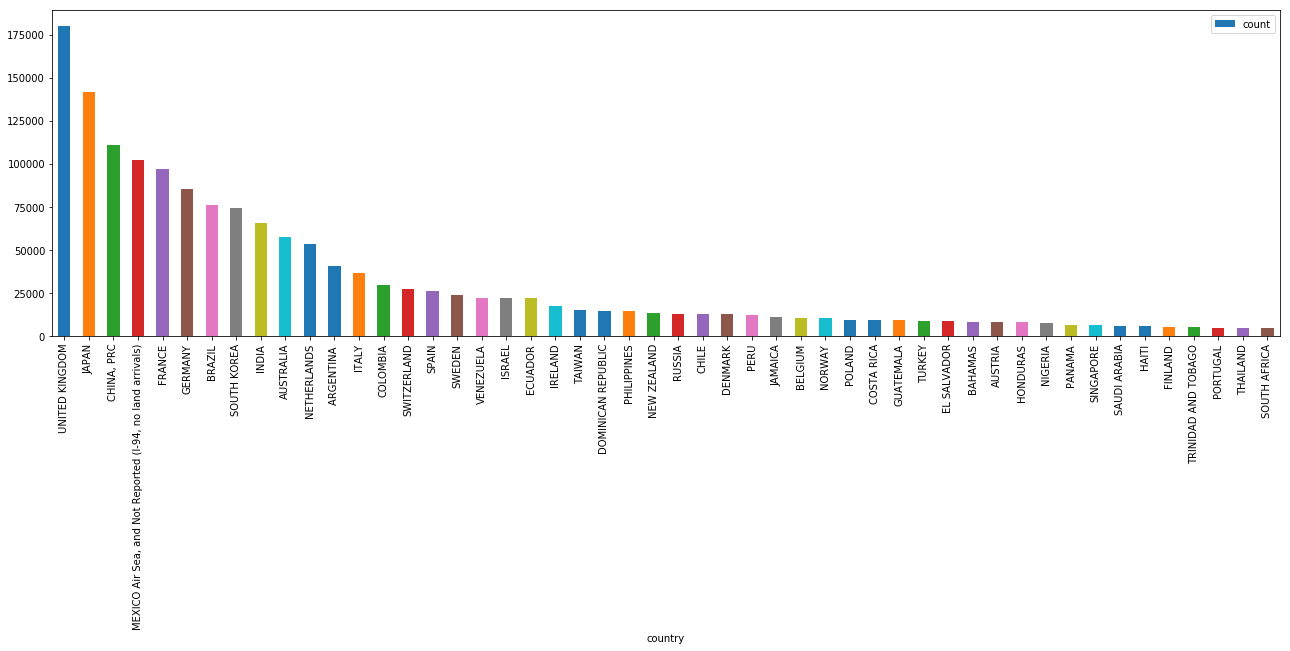

In [9]:
# first load the country codes mapping file 
file_pathname = 'country_codes'
S3_bucket_country_codes = os.path.join('s3a://',S3_BUCKET, S3_PROC_DATA_JSON, file_pathname )

df_I94CIT_RES = spark.read.json(S3_bucket_country_codes)

# join count_visitor df with port_mapping df
df_I94_count_visitors.limit(50).join(df_I94CIT_RES.withColumnRenamed('code','i94res'), on="i94res", how="leftouter")\
                                                                        .toPandas().plot.bar(x='country', y='count', figsize=(22,6))
plt.show()

As we can see, the **highest number of visitors** come from the United Kingdom

##### Query 3. In the given period, what port registered the highest number of arrivals?

In [10]:
first_day = '2016-04-15'
last_day  = '2016-04-30'

df_I94 = spark.read.format("parquet").load(S3_bucket_I94).where((col('arrdate')>=first_day) & (col('arrdate')<=last_day))

df_I94_total_arrivals_per_port = df_I94.groupBy('i94port').count().sort(col('count').desc())
df_I94_total_arrivals_per_port.show(10)

+-------+------+
|i94port| count|
+-------+------+
|    NYC|270691|
|    MIA|190419|
|    LOS|168991|
|    SFR| 84952|
|    ORL| 81976|
|    HHW| 78090|
|    NEW| 77083|
|    CHI| 72433|
|    HOU| 56813|
|    FTL| 51986|
+-------+------+
only showing top 10 rows



Let's join it with the port code mapping file

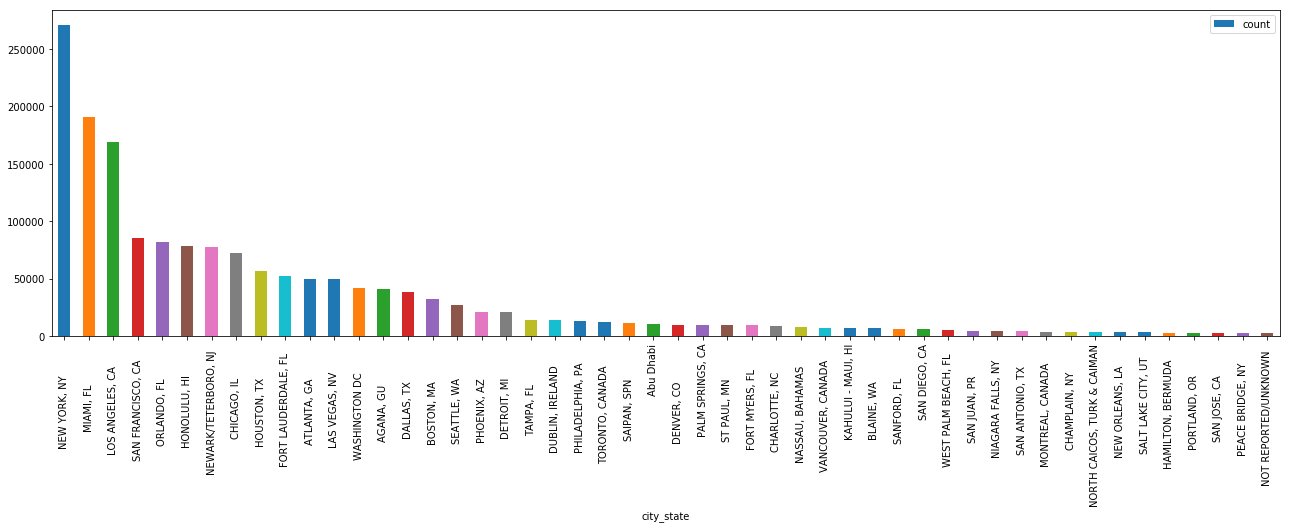

In [11]:
# first load the port codes mapping file 
file_pathname = 'port_codes'
S3_bucket_port_codes = os.path.join('s3a://',S3_BUCKET, S3_PROC_DATA_JSON, file_pathname )

df_I94PORT = spark.read.json(S3_bucket_port_codes)

df_I94_total_arrivals_per_port.limit(50).join(df_I94PORT.withColumnRenamed('code','i94port'), on='i94port', how='leftouter')\
                                .toPandas().plot.bar(x='city_state', y='count', figsize=(22,6))
plt.show()

##### Query 4. Number of arrivals in a given city for a given period

In this query the data analyst want to see how many arrivals day-by-day have been recorded in a specific city, say **Kansas city**.

First we need the code corresponding to Kansas city.

In [12]:
city_to_query = 'KANSAS CITY'
df_i94_port = spark.read.format('json').load('data/S3bucket_temp/port_codes').where(col('city').like(city_to_query))
city_code = df_i94_port.select('code').collect()[0]['code']

city_code

'KAN'

In [13]:
first_day = '2016-04-1'
last_day  = '2016-04-30'

df_I94 = spark.read.format("parquet").load(S3_bucket_I94).where((col('arrdate')>=first_day) & (col('arrdate')<=last_day))

df_query_1 = df_I94.select('i94port', 'arrdate', 'count')\
                    .filter(col('i94port')=='KAN')\
                    .groupBy('arrdate')\
                    .count().withColumnRenamed('count', 'filed_in_'+city_to_query)\
                    .orderBy('arrdate')

df_query_1.show(5)

+----------+--------------------+
|   arrdate|filed_in_KANSAS CITY|
+----------+--------------------+
|2016-04-10|                   2|
|2016-04-11|                   8|
|2016-04-12|                   3|
|2016-04-13|                  20|
|2016-04-14|                  22|
+----------+--------------------+
only showing top 5 rows



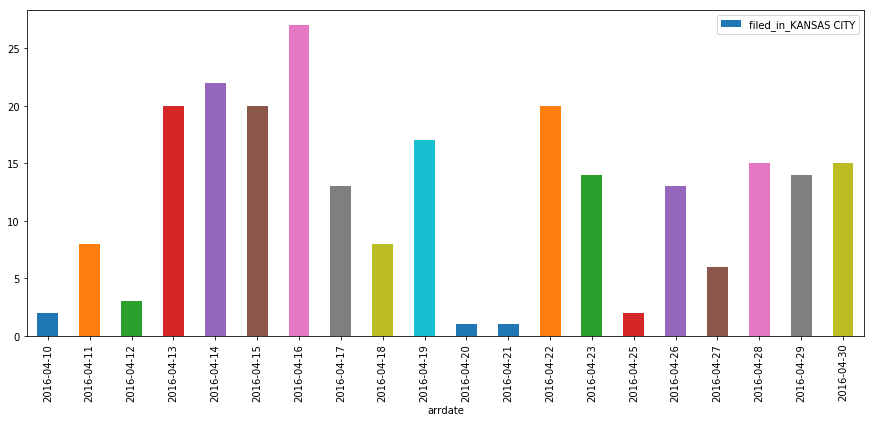

In [14]:
df_query_1.toPandas().plot.bar(x='arrdate', y=('filed_in_'+city_to_query), figsize=(15,6))
plt.show()

There isn't really a recognizable pattern, nor a exceptionally high spike of record filed in one day.

Out of curiosity let's repeat it for another city: New York

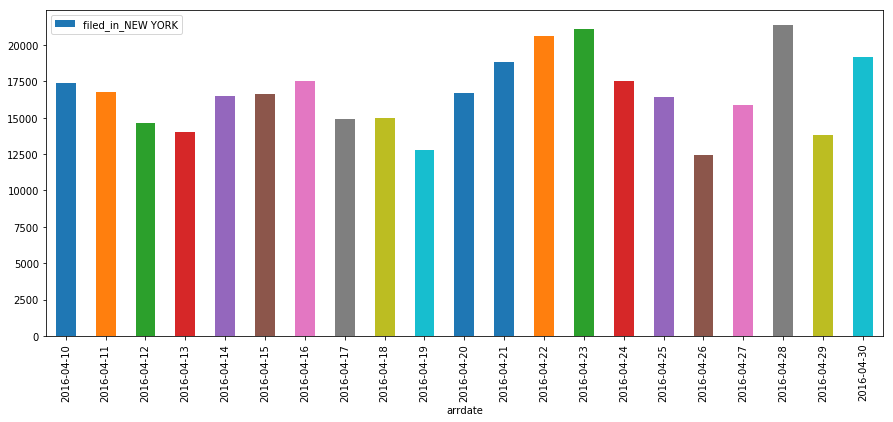

In [15]:
city_to_query = 'NEW YORK'
df_i94_port = spark.read.format('json').load('data/S3bucket_temp/port_codes').where(col('city').contains(city_to_query))
city_code = df_i94_port.select('code').collect()[0]['code']

first_day = '2016-04-1'
last_day  = '2016-04-30'

df_I94 = spark.read.format("parquet").load(S3_bucket_I94).where((col('arrdate')>=first_day) & (col('arrdate')<=last_day))

df_query_1 = df_I94.select('i94port', 'arrdate', 'count')\
                    .filter(col('i94port')==city_code)\
                    .groupBy('arrdate')\
                    .count().withColumnRenamed('count', 'filed_in_'+city_to_query)\
                    .orderBy('arrdate')

df_query_1.toPandas().plot.bar(x='arrdate', y=('filed_in_'+city_to_query), figsize=(15,6))
plt.show()

##### Query 5. Travelers genders

- In 2020 the world population was 50.4% male and 49.6% female ([source](https://www.ined.fr/en/everything_about_population/demographic-facts-sheets/faq/more-men-or-women-in-the-world/)). Is this gender distribution mirrored in the traveler number? 

In [16]:
df_I94 = spark.read.format("parquet").load(S3_bucket_I94)

df_I94_query = df_I94.select('i94port', 'gender', 'count')\
                     .groupBy('gender')\
                     .sum('count')

In [17]:
df_I94_query.show()

+------+----------+
|gender|sum(count)|
+------+----------+
|     F|   1302743|
|  null|    414269|
|     M|   1377224|
|     U|       467|
|     X|      1610|
+------+----------+



In [18]:
num_visitors = df_I94.filter((col('gender')==lit('M')) | (col('gender')==lit('F'))).count()
num_visitors

2679967

In [19]:
df_I94_query.filter((col('gender')==lit('M')) | (col('gender')==lit('F'))).withColumn('percent', col("sum(count)")/num_visitors*100).show()

+------+----------+------------------+
|gender|sum(count)|           percent|
+------+----------+------------------+
|     F|   1302743|48.610411993879026|
|     M|   1377224| 51.38958800612097|
+------+----------+------------------+



##### Query 6. Is there a city where the difference between male and female travelers is more evident?

In [20]:
df_I94_query = spark.read.format("parquet").load(S3_bucket_I94)\
                                            .select('i94port', 'gender', 'count')\
                                            .groupBy('i94port')\
                                            .pivot('gender')\
                                            .sum('count')

In [21]:
df_I94_query.show(10)

+-------+----+----+----+----+----+
|i94port|null|   F|   M|   U|   X|
+-------+----+----+----+----+----+
|    FMY|1518|8087|7904|   1|   4|
|    BGM|null|  24| 104|null|null|
|    HEL|null|   1|   1|null|null|
|    DNS|null|  14|  21|null|null|
|    MOR|null|   5|   9|null|null|
|    HVR|   1|   7|  37|null|null|
|    FOK|null|   2|  12|null|null|
|    SNA|   4|3414|3648|null|null|
|    PTK|null|null|  12|null|null|
|    SPM|2280|6755|7931|null|   7|
+-------+----+----+----+----+----+
only showing top 10 rows



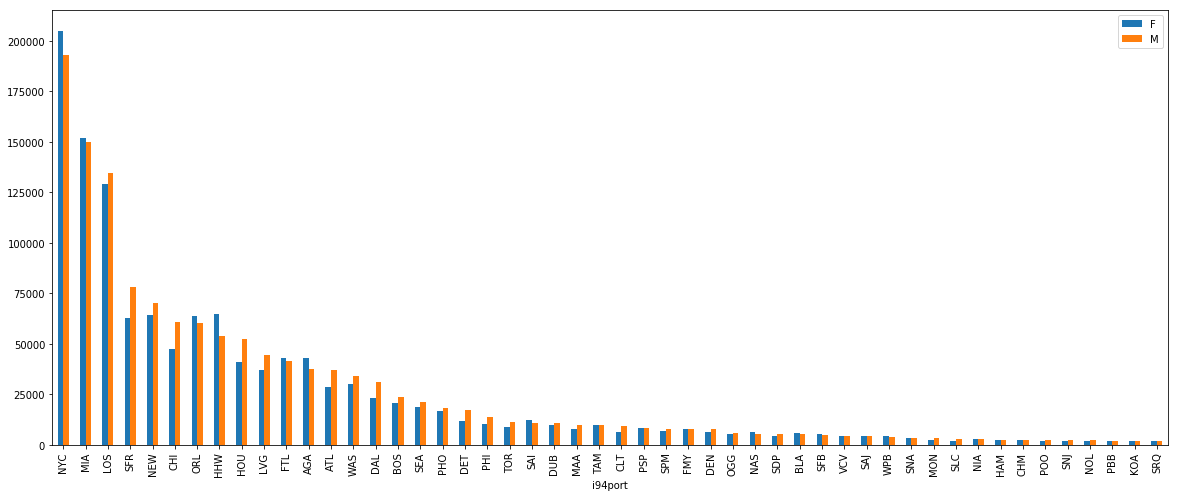

In [22]:
df_I94_query.select('i94port','F','M').orderBy(col('M').desc()).limit(50).toPandas().plot.bar(x='i94port',figsize=(20,8))
plt.show()

Visually, 4 cities show the biggest difference in visitors' genders:
- in San Francisco (SFR) and Chigago (CHI) arrived more men
- in New York (NYC) and Honolulu (HHW) arrived more women

##### Query 7. Find most visited city (the function)

The query requests to aggregate the total number of visitors at each PORT of arrival. Additionally they will be ordered in descending order.

The query load the data from the parquet files on S3. A custom time range can be defined passing the first_date and end_date arguments to the function. 

In [23]:
def find_most_visited_cities_period(S3_bucket, year=None, month=None, start_date=None, end_date=None):
    """
    Supported queries:
    - passing only the year as parameter
    - passing year and month
    - passing custom start and end date in the format "yyyy-MM-dd"
    """
    
    if year!=None and month==None and start_date==None and end_date==None: # 1 year time range
        start_date = str(year)+"-01-01"
        end_date   = str(year)+"-12-31"
        df_I94_pre = spark.read.format('parquet').load(S3_bucket).where((col('i94yr')==year))
    
    elif year!=None and month!=None and start_date==None and end_date==None: # 1 month time range
        df_I94_pre = spark.read.format('parquet').load(S3_bucket).where(
                            (col('i94yr')==year) & (col('i94mon')==month))
        
    elif year==None and month==None and start_date!=None and end_date!=None: # custom time range
        df_I94_pre = spark.read.format('parquet').load(S3_bucket).where(
                            (col('dtadfile')>=to_timestamp(lit(start_date))) & 
                            (col('dtadfile')<=to_timestamp(lit(end_date))))

    df = df_I94_pre.groupBy('i94port')\
          .sum('count')\
          .sort(col('sum(count)').desc())\
          .withColumnRenamed('sum(count)', 'Total_Visitors')
    
    return df

*Query 1 test #1*

In [24]:
find_most_visited_cities_period(S3_bucket_I94, 2016, 4).toPandas().head()

,i94port,Total_Visitors
0,NYC,485916
1,MIA,343941
2,LOS,310163
3,SFR,152586
4,ORL,149195


*Query 1 test #2*

In [25]:
find_most_visited_cities_period(S3_bucket_I94, 2016).toPandas().head()

,i94port,Total_Visitors
0,NYC,485916
1,MIA,343941
2,LOS,310163
3,SFR,152586
4,ORL,149195


*Query 1 test #3*

In [26]:
find_most_visited_cities_period(S3_bucket_I94, start_date='2016-04-01', end_date='2016-04-30').toPandas().head()

,i94port,Total_Visitors
0,NYC,483686
1,MIA,341936
2,LOS,309009
3,SFR,151644
4,ORL,147776


As can be seen I get less visitors in the last test despite having the same time range although expressed differently.

This is because the dataset has many **null** and some wrong date in the **dtadfile** column. 

## Run the queries on EMR
Running  `python emr_cluster_submit-Queries.py` an EMR cluster is created and the file **spark_4_emr-Queries.py** is added as step in EMR taskflow.

Queries results are saved in s3://helptheplanet/queries/query_results.json